In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
np.random.seed = 42

c:\Users\66891\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('learning_set.csv')
df.head()

,Age,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,Lung_Cancer_Diagnosis,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Total_Exposure,Cigarettes_Total,Age_Smoking_Effect,Smoking_Burden,Exposure_Index,Health_Risk_Score,Gender_Female,Gender_Male
0,80,30,29,0,0,0,0,1,0,0,1,317550,2400,317550,32.0,80.0,0,1
1,53,0,0,1,0,0,0,1,0,0,1,0,0,1000,2.0,53.0,0,1
2,47,12,6,1,0,0,1,0,0,0,1,26280,564,54560,7.0,47.0,0,1
3,39,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,44.0,1,0
4,44,0,0,1,0,0,1,1,0,0,2,0,0,2000,3.0,44.0,1,0


In [3]:
# Sprawdź brakujące wartości
print(df.isnull().sum())

# Sprawdź typy danych
print(df.dtypes)


Age                       0
Years_of_Smoking          0
Cigarettes_per_Day        0
Passive_Smoker            0
Family_History            0
Lung_Cancer_Diagnosis     0
Air_Pollution_Exposure    0
Occupational_Exposure     0
Indoor_Pollution          0
Healthcare_Access         0
Total_Exposure            0
Cigarettes_Total          0
Age_Smoking_Effect        0
Smoking_Burden            0
Exposure_Index            0
Health_Risk_Score         0
Gender_Female             0
Gender_Male               0
dtype: int64
Age                         int64
Years_of_Smoking            int64
Cigarettes_per_Day          int64
Passive_Smoker              int64
Family_History              int64
Lung_Cancer_Diagnosis       int64
Air_Pollution_Exposure      int64
Occupational_Exposure       int64
Indoor_Pollution            int64
Healthcare_Access           int64
Total_Exposure              int64
Cigarettes_Total            int64
Age_Smoking_Effect          int64
Smoking_Burden              int64
Exposur

In [4]:
# Zakładamy, że kolumna celu nazywa się:
target_column = 'Lung_Cancer_Diagnosis'

X = df.drop(columns=[target_column])
y = df[target_column]


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,        # zachowujemy proporcje klas!
    random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Train class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")


Train size: (149600, 17), Test size: (64115, 17)
Train class distribution:
Lung_Cancer_Diagnosis
0    0.960401
1    0.039599
Name: proportion, dtype: float64
Test class distribution:
Lung_Cancer_Diagnosis
0    0.960399
1    0.039601
Name: proportion, dtype: float64


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Model bazowy
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Predykcje
y_pred = model.predict(X_test_scaled)

# Ocena
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     61576
           1       0.00      0.00      0.00      2539

    accuracy                           0.96     64115
   macro avg       0.48      0.50      0.49     64115
weighted avg       0.92      0.96      0.94     64115

[[61576     0]
 [ 2539     0]]


In [8]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)


In [9]:
model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [10]:
y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.64      0.78     61576
           1       0.07      0.66      0.13      2539

    accuracy                           0.64     64115
   macro avg       0.52      0.65      0.45     64115
weighted avg       0.94      0.64      0.75     64115

[[39517 22059]
 [  866  1673]]


In [11]:
"""
from sklearn.model_selection import GridSearchCV

# Definiujemy parametry, które chcemy testować
param_grid = [
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [200, 500, 1000]
    },
    {
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [200, 500, 1000]
    }
]

# Inicjalizujemy model
model = LogisticRegression(class_weight='balanced', random_state=42)

# Tworzymy obiekt GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Trenujemy model
grid_search.fit(X_train_scaled, y_train)

# Najlepszy model i jego parametry
print("Best hyperparameters:", grid_search.best_params_)
"""

'\nfrom sklearn.model_selection import GridSearchCV\n\n# Definiujemy parametry, które chcemy testować\nparam_grid = [\n    {\n        \'solver\': [\'liblinear\'],\n        \'penalty\': [\'l1\', \'l2\'],\n        \'C\': [0.01, 0.1, 1, 10, 100],\n        \'max_iter\': [200, 500, 1000]\n    },\n    {\n        \'solver\': [\'newton-cg\', \'lbfgs\', \'sag\', \'saga\'],\n        \'penalty\': [\'l2\'],\n        \'C\': [0.01, 0.1, 1, 10, 100],\n        \'max_iter\': [200, 500, 1000]\n    }\n]\n\n# Inicjalizujemy model\nmodel = LogisticRegression(class_weight=\'balanced\', random_state=42)\n\n# Tworzymy obiekt GridSearchCV\ngrid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=\'f1\', n_jobs=-1, verbose=1)\n\n# Trenujemy model\ngrid_search.fit(X_train_scaled, y_train)\n\n# Najlepszy model i jego parametry\nprint("Best hyperparameters:", grid_search.best_params_)\n'

In [12]:
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.DataFrame(grid_search.cv_results_)
results['params_str'] = results['params'].apply(lambda d: ', '.join(f'{k}={v}' for k, v in d.items()))
results_sorted = results.sort_values(by='mean_test_score', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(data=results_sorted.head(10), x='mean_test_score', y='params_str', palette='crest')
plt.xlabel('F1-score (średnia z 5-krotnej walidacji)')
plt.ylabel('Zestaw hiperparametrów')
plt.title('Top 20 kombinacji hiperparametrów według F1-score')
plt.tight_layout()
plt.show()

"""

"\n\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nresults = pd.DataFrame(grid_search.cv_results_)\nresults['params_str'] = results['params'].apply(lambda d: ', '.join(f'{k}={v}' for k, v in d.items()))\nresults_sorted = results.sort_values(by='mean_test_score', ascending=False)\n\nplt.figure(figsize=(12, 7))\nsns.barplot(data=results_sorted.head(10), x='mean_test_score', y='params_str', palette='crest')\nplt.xlabel('F1-score (średnia z 5-krotnej walidacji)')\nplt.ylabel('Zestaw hiperparametrów')\nplt.title('Top 20 kombinacji hiperparametrów według F1-score')\nplt.tight_layout()\nplt.show()\n\n"

In [13]:
"""
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='param_C', y='mean_test_score', hue='param_solver', style='param_penalty', s=100)
plt.title('Wpływ wartości C na F1-score (podział na solver i penalty)')
plt.xlabel('Wartość C')
plt.ylabel('F1-score (średnia)')
plt.grid(True)
plt.tight_layout()
plt.show()
"""

"\nplt.figure(figsize=(10, 6))\nsns.scatterplot(data=results, x='param_C', y='mean_test_score', hue='param_solver', style='param_penalty', s=100)\nplt.title('Wpływ wartości C na F1-score (podział na solver i penalty)')\nplt.xlabel('Wartość C')\nplt.ylabel('F1-score (średnia)')\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n"

In [14]:
from sklearn.linear_model import LogisticRegression

best_model = LogisticRegression(
    C=1,
    max_iter=500,
    penalty='l2',
    solver='sag',
    class_weight='balanced',
    random_state=42
)

best_model.fit(X_train_scaled, y_train)


LogisticRegression(C=1, class_weight='balanced', max_iter=500, random_state=42,
                   solver='sag')

              precision    recall  f1-score   support

           0       0.98      0.64      0.78     61576
           1       0.07      0.66      0.13      2539

    accuracy                           0.64     64115
   macro avg       0.52      0.65      0.45     64115
weighted avg       0.94      0.64      0.75     64115



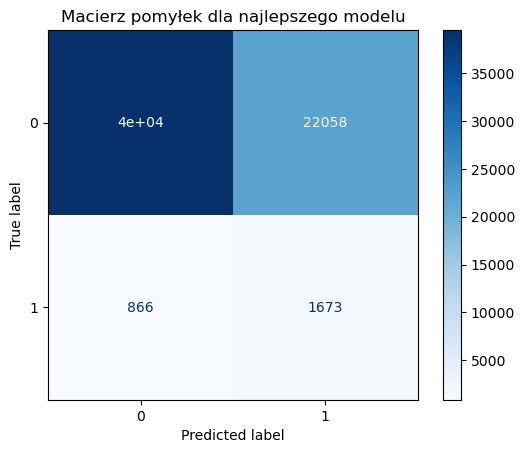

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test_scaled)

# Raport klasyfikacji
print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Macierz pomyłek dla najlepszego modelu")
plt.show()


In [17]:

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
#from xgboost import XGBClassifier

# Lista modeli do przetestowania
models = {
    "Logistic Regression": LogisticRegression(C=1, max_iter=500, penalty='l2', solver='sag', class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    #"XGBoost": XGBClassifier(scale_pos_weight=24, use_label_encoder=False, eval_metric='logloss', random_state=42),  # 24 = ratio majority/minority
    #"SVC": SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}


In [18]:
results = {}

for name, model in models.items():
    print(f"\n🔍 Trenuję model: {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Metryki
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = f1_score(y_test, y_pred)
    results[name] = {
        "f1_score (class 1)": f1,
        "recall (class 1)": report['1']['recall'],
        "precision (class 1)": report['1']['precision'],
        "accuracy": report['accuracy']
    }

    print(classification_report(y_test, y_pred))



🔍 Trenuję model: Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.64      0.78     61576
           1       0.07      0.66      0.13      2539

    accuracy                           0.64     64115
   macro avg       0.52      0.65      0.45     64115
weighted avg       0.94      0.64      0.75     64115


🔍 Trenuję model: Random Forest
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     61576
           1       0.02      0.02      0.02      2539

    accuracy                           0.92     64115
   macro avg       0.49      0.49      0.49     64115
weighted avg       0.92      0.92      0.92     64115


🔍 Trenuję model: MLP (Neural Net)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     61576
           1       0.00      0.00      0.00      2539

    accuracy                           0.96     64115
   macro avg       0.48

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Parametry do testowania
param_grid = {
    'n_estimators': [100, 200, 300],           # liczba drzew
    'max_depth': [10, 20, None],               # maksymalna głębokość drzewa
    'min_samples_split': [2, 5, 10],           # minimalna liczba próbek do podziału
    'min_samples_leaf': [1, 2, 4],             # minimalna liczba próbek w liściu
    'max_features': ['auto', 'sqrt', 'log2']   # liczba cech branych pod uwagę przy każdym podziale
}

# Model RandomForest
rf = RandomForestClassifier(random_state=42)

# Tworzymy obiekt GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)

# Trening modelu
grid_search.fit(X_train_scaled, y_train)

# Najlepsze parametry
print("Best hyperparameters:", grid_search.best_params_)
#TO zAJUMJE DŁUGO! dokoncze jutro

Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 